In [1]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

# reading docfiles
import docx2txt

#nltk
import nltk
from nltk.tokenize import word_tokenize

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
word_exclusions = pd.read_excel("input/word_exclusions.xlsx")

word_exclusions = word_exclusions[word_exclusions["exclude"] == 1]

word_exclusions = word_exclusions.drop(columns=['exclude', 'exclude_short_list'], axis = 1)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('german')
stop_words.extend(word_exclusions["word"])
stop_words.extend(["gut"])

In [4]:
df = pd.read_excel("input/app_v2/app_v2_feedback.xlsx")

In [5]:
df.head()

,transcript_id,person_id,segment_id,context,lesson,text,category_id
0,tn_01,p01,s_001,NaN,NaN,"Ja, ich höre Sie ein bisschen schlecht. Das ha...",2
1,tn_01,p01,s_002,NaN,NaN,"Ja, jetzt ist es ein bisschen besser. Ja.",2
2,tn_01,p01,s_003,"Ok, gut. Also… Ich habe jetzt das Aufnahmeger...",NaN,Ok. Ja.,1
3,tn_01,p01,s_004,NaN,NaN,"So ein Diktiergerät quasi. Ja, ja. Mhm.",2
4,tn_01,p01,s_005,Und ich spreche Sie jetzt auch nicht mit dem N...,NaN,"Ok, dann machen wir das so. Ja!",1


In [6]:
strengths = df[df["category_id"] == 9]

In [7]:
strengths = strengths.drop(columns=['transcript_id', 'person_id', 'segment_id', 'context', 'lesson', 'category_id'], 
             axis = 1)

In [8]:
strengths['text_processed'] = \
strengths['text'].map(lambda x: re.sub('[,.!?]', '', x))

In [9]:
strengths['text_processed'] = \
strengths['text_processed'].map(lambda x: x.lower())

In [10]:
feedback = strengths['text_processed']

feedback_token = feedback.apply(word_tokenize)
feedback_token.head()

21    [also, was, mir, jetzt, besonders, gefallen, h...
22    [das, finde, ich, halt, richtig, toll, dass, d...
27    [ja, also, quasi…, es, gibt, ja, dieses, eine,...
33    [genau, also…, bei, empathie, das, fand, ich, ...
39    [ja, genau, dann, das, siebte, kapitel, –, mit...
Name: text_processed, dtype: object

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), 
                                             deacc = True))

In [12]:
data = strengths.text_processed.values.tolist()
data_words = list(sent_to_words(data))

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['also', 'was', 'mir', 'jetzt', 'besonders', 'gefallen', 'hat', 'ist', 'diese']


In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(feedback_token)

In [16]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [17]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("de_core_news_sm", disable = ['parser', 'ner'])

In [18]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['besonders', 'fallen']]


In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [20]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('besonders', 1), ('fallen', 1)]]

In [25]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [26]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.052*"finden" + 0.022*"immer" + 0.018*"vielleicht" + 0.016*"reingegucken" '
  '+ 0.016*"abend" + 0.015*"glauben" + 0.015*"sagen" + 0.013*"funktionieren" + '
  '0.012*"app" + 0.011*"Problem"'),
 (1,
  '0.056*"finden" + 0.026*"machen" + 0.023*"Fall" + 0.021*"einfach" + '
  '0.018*"Fand" + 0.016*"sagen" + 0.013*"verstehen" + 0.012*"wissen" + '
  '0.011*"wirklich" + 0.011*"gestalten"')]


In [27]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.32012261145823

Coherence Score:  0.3902114491616201


In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.096291  0.0       1        1  56.338656
0     -0.096291  0.0       2        1  43.661344, topic_info=             Term       Freq      Total Category  logprob  loglift
57           Fall  14.000000  14.000000  Default  30.0000  30.0000
11         machen  17.000000  17.000000  Default  29.0000  29.0000
475  reingegucken   8.000000   8.000000  Default  28.0000  28.0000
452         abend   8.000000   8.000000  Default  27.0000  27.0000
81           Fand  12.000000  12.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
200       positiv   4.455720   6.097383   Topic2  -4.7097   0.5150
70        einfach   5.127897  18.709226   Topic2  -4.5692  -0.4656
185        wissen   4.596347  12.133156   Topic2  -4.6787  -0.1420
18       wirklich   4.457647  11.786628   Topic2  -4.7093  -0.1436
227         heute   4.169162   5.009215   Topic2  -4.7762   0.6451

[112 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
461       2  0.867419    Angefang
462       2  0.867419  Erinnerung
57        1  0.945372        Fall
81        1  0.988992        Fand
160       1  0.728124      Geburt
...     ...       ...         ...
18        1  0.593893    wirklich
18        2  0.339368    wirklich
185       1  0.659350      wissen
185       2  0.412094      wissen
470       2  0.867519      zuerst

[98 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=num_topics, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=1, 
                                                        limit=30, 
                                                        step=1)

In [26]:
os.chdir("C:\\Users\\vanandkuma\\Documents\\projects\\sentiment_analysis")

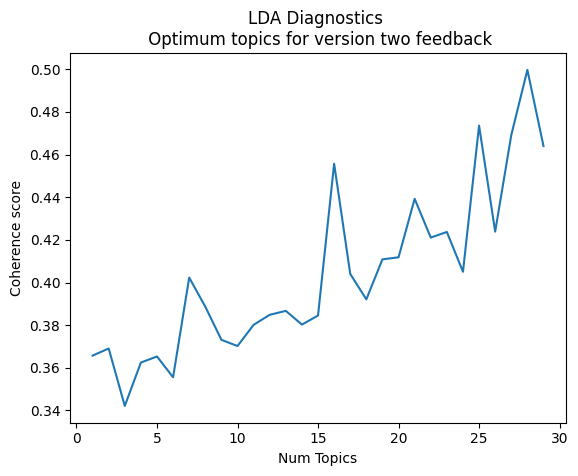

In [27]:
# Show graph
limit=30; start=1; step=1;
x = range(start, limit, step)
plt.title("LDA Diagnostics \n Optimum topics for version two feedback")
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.savefig('output/app_v1_lda_topic_coherence.png')

In [28]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.3657
Num Topics = 2  has Coherence Value of 0.3691
Num Topics = 3  has Coherence Value of 0.3421
Num Topics = 4  has Coherence Value of 0.3625
Num Topics = 5  has Coherence Value of 0.3653
Num Topics = 6  has Coherence Value of 0.3556
Num Topics = 7  has Coherence Value of 0.4023
Num Topics = 8  has Coherence Value of 0.3887
Num Topics = 9  has Coherence Value of 0.3731
Num Topics = 10  has Coherence Value of 0.3702
Num Topics = 11  has Coherence Value of 0.3802
Num Topics = 12  has Coherence Value of 0.3849
Num Topics = 13  has Coherence Value of 0.3867
Num Topics = 14  has Coherence Value of 0.3803
Num Topics = 15  has Coherence Value of 0.3845
Num Topics = 16  has Coherence Value of 0.4557
Num Topics = 17  has Coherence Value of 0.404
Num Topics = 18  has Coherence Value of 0.3921
Num Topics = 19  has Coherence Value of 0.4109
Num Topics = 20  has Coherence Value of 0.4118
Num Topics = 21  has Coherence Value of 0.4393
Num Topics = 22  has Co

In [30]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.056*"lernen" + 0.029*"mögen" + 0.029*"uber" + 0.026*"Frage" + '
  '0.020*"geben" + 0.019*"stellen" + 0.019*"fur" + 0.015*"personlich" + '
  '0.015*"Person" + 0.015*"hineinversetzen"'),
 (1,
  '0.052*"finden" + 0.041*"gut" + 0.029*"Lektion" + 0.020*"einfach" + '
  '0.020*"eigen" + 0.016*"Kommunikation" + 0.013*"Klicke" + 0.013*"personlich" '
  '+ 0.012*"kurz" + 0.011*"mögen"'),
 (2,
  '0.055*"gut" + 0.055*"finden" + 0.035*"Beispiel" + 0.021*"immer" + '
  '0.018*"geben" + 0.018*"Alltag" + 0.013*"personlich" + 0.013*"wichtig" + '
  '0.013*"mögen" + 0.013*"wirklich"'),
 (3,
  '0.027*"Thema" + 0.024*"nie" + 0.024*"bissch" + 0.024*"mögen" + '
  '0.023*"Geburt" + 0.020*"Seite" + 0.020*"finden" + 0.017*"Kommunikation" + '
  '0.016*"fur" + 0.014*"spannend"'),
 (4,
  '0.051*"Lektion" + 0.039*"gut" + 0.039*"Idee" + 0.026*"mögen" + '
  '0.026*"finden" + 0.026*"kommen" + 0.014*"total" + 0.014*"folgen" + '
  '0.014*"dazwischen" + 0.014*"Kleinigkeit"'),
 (5,
  '0.077*"mögen" + 0.028*"neutra

In [29]:
pyLDAvis.save_html(vis, 'output/ldavis_app_v2_strengths.html')

C:\Users\vanandkuma\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\_memmapping_reducer.py:611: UserWarning: Failed to delete temporary folder: C:\Users\VANAND~1\AppData\Local\Temp\joblib_memmapping_folder_125576_90ca2727f41549cbb85a80d5cf0b3d96_de8be880c8a4489998569f2c01a5f140
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\vanandkuma\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\_memmapping_reducer.py:611: UserWarning: Failed to delete temporary folder: C:\Users\VANAND~1\AppData\Local\Temp\joblib_memmapping_folder_125576_100ec96b104d480082926de9f8f9efd2_ecbb76d8e51b45e6adb02cab8b8e01d3
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\vanandkuma\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\_memmapping_reducer.py:611: UserWarning: Failed to delete temporary folder: C:\Users\VANAND~1\AppData\Local\Temp\joblib_memmapping_folder_125576_90ca2727f41549cbb85a80d5cf0b3d96_858b8474fb3049aca2efa8f43b418cc7
